In [6]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
rcParams['figure.figsize'] = 15, 6
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.statespace.mlemodel
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from math import sqrt

NameError: name 'rcParams' is not defined

In [512]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [3]:
data = pd.read_csv("H:\KaggleCompetitions\CallVolumeForecast\CallVolumeData.csv",index_col="Date",parse_dates=True,infer_datetime_format = True)
data.describe()
data.head()


,CallVolume
Date,
2011-01-03,3228.0
2011-01-04,3368.0
2011-01-05,3293.0
2011-01-06,3130.0
2011-01-07,2901.0


In [ ]:
data.tail()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024F7E94ABA8>]], dtype=object)

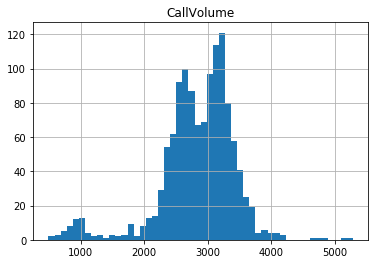

In [5]:
data.hist(bins=50)

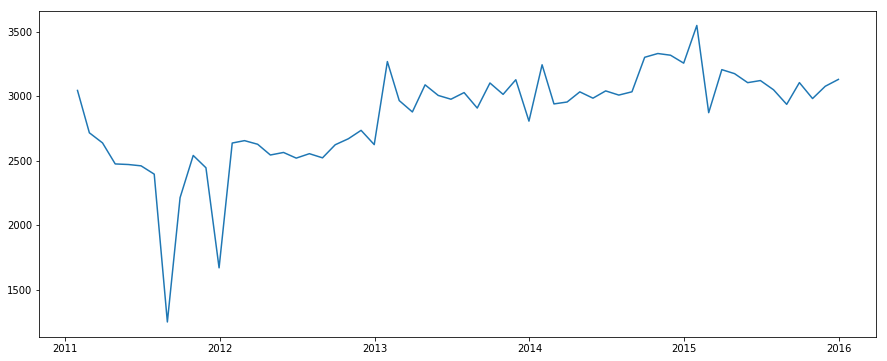

In [128]:
#data.resample('W').mean()
plt.plot(data.resample('M').mean())
plt.show()

In [515]:
ts =data['CallVolume']

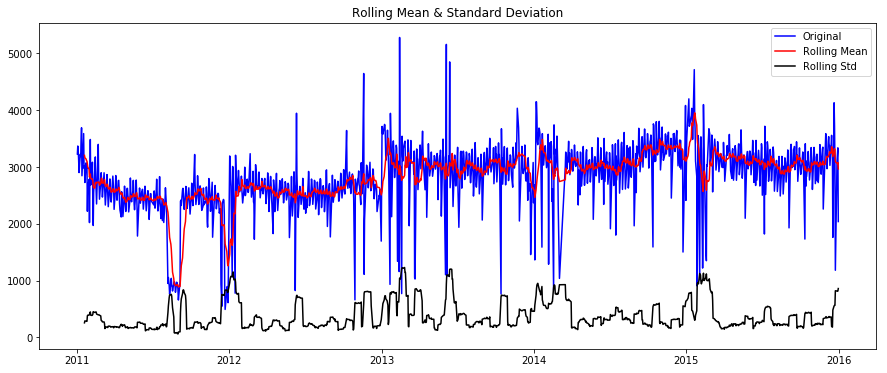

Results of Dickey-Fuller Test:
Test Statistic                   -4.273623
p-value                           0.000493
#Lags Used                       13.000000
Number of Observations Used    1234.000000
Critical Value (1%)              -3.435660
Critical Value (5%)              -2.863885
Critical Value (10%)             -2.568019
dtype: float64


In [398]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries.dropna()).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts)

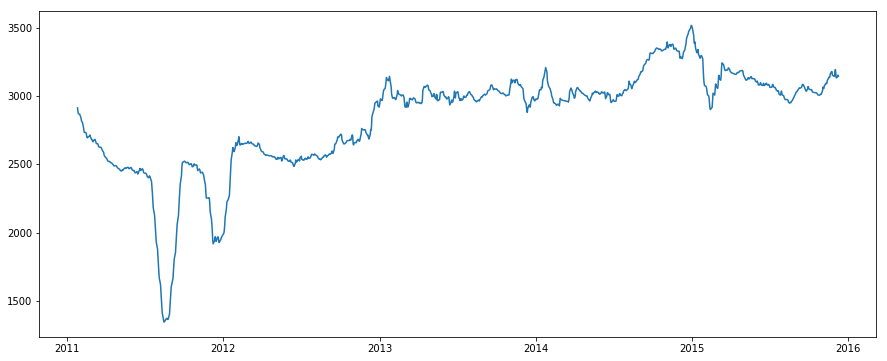

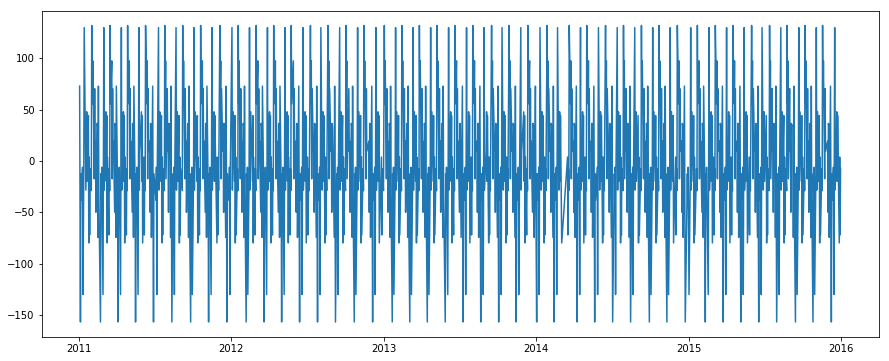

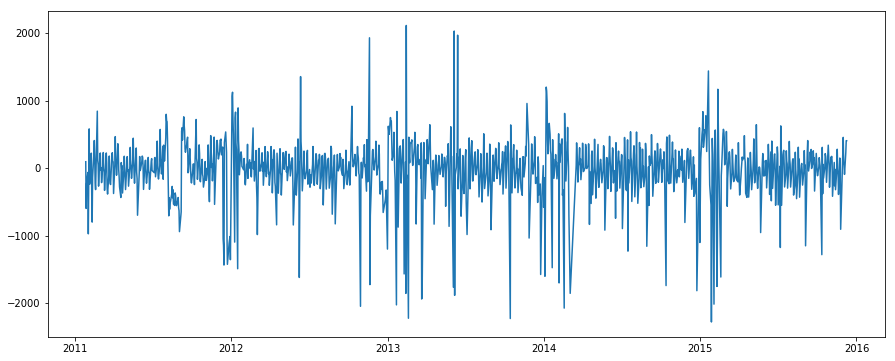

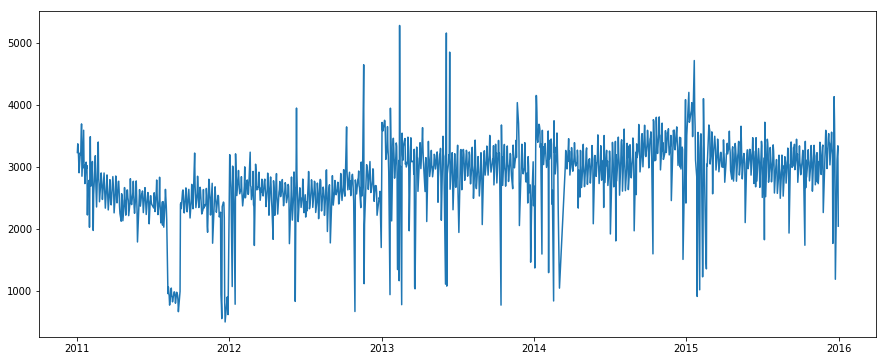

In [447]:
ts_decompose = seasonal_decompose(ts,freq=30,model='additive')
plt.subplot(111)
plt.plot(ts_decompose.trend)
plt.show()
plt.subplot(111)
plt.plot(ts_decompose.seasonal)
plt.show()
plt.subplot(111)
plt.plot(ts_decompose.resid)
plt.show()
plt.subplot(111)
plt.plot(ts_decompose.observed)
plt.show()

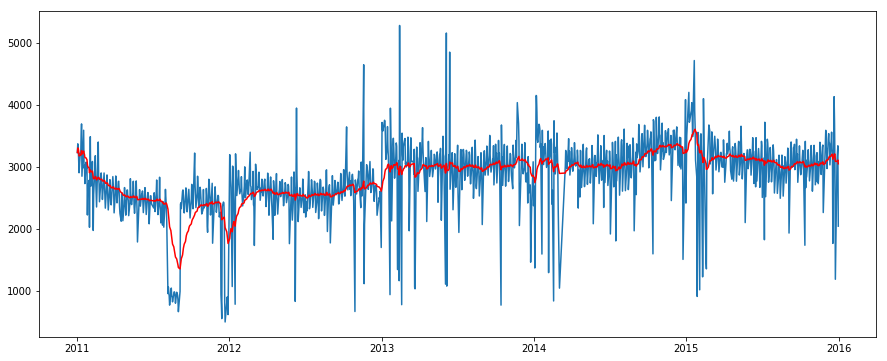

In [188]:
expwighted_avg = pd.Series(ts).ewm(halflife=12).mean()
plt.plot(ts)
plt.plot(expwighted_avg, color='red')

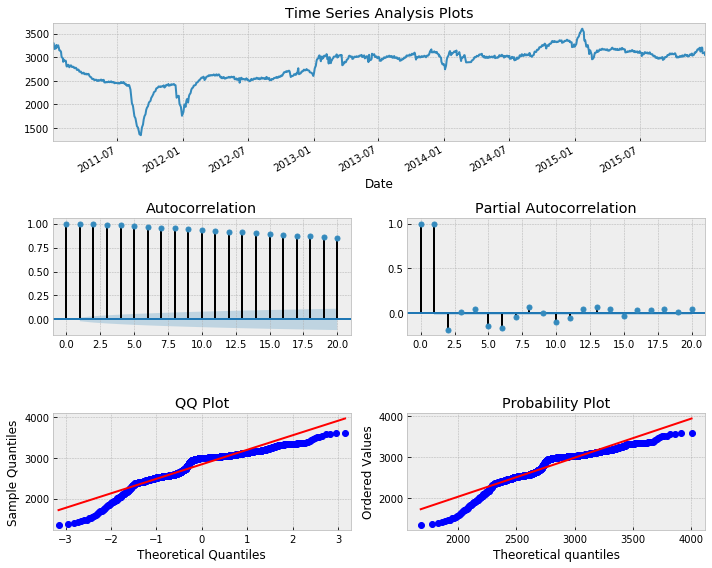

In [530]:
tsplot(expwighted_avg,lags=20)

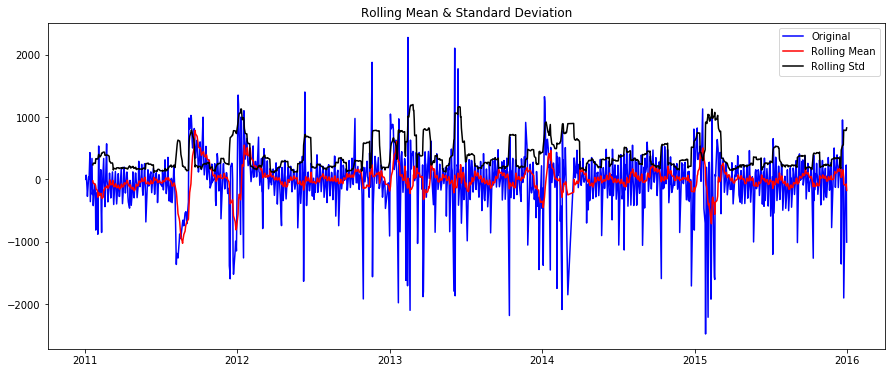

Results of Dickey-Fuller Test:
Test Statistic                -7.987185e+00
p-value                        2.530490e-12
#Lags Used                     2.200000e+01
Number of Observations Used    1.225000e+03
Critical Value (1%)           -3.435699e+00
Critical Value (5%)           -2.863902e+00
Critical Value (10%)          -2.568028e+00
dtype: float64


In [344]:
ts_ewma_diff = ts - expwighted_avg
test_stationarity(ts_ewma_diff)

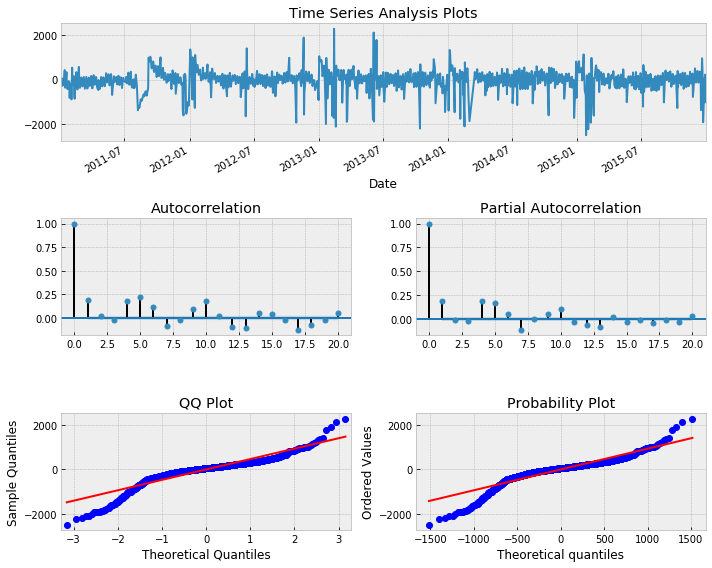

In [531]:
tsplot(ts_ewma_diff,lags=20)

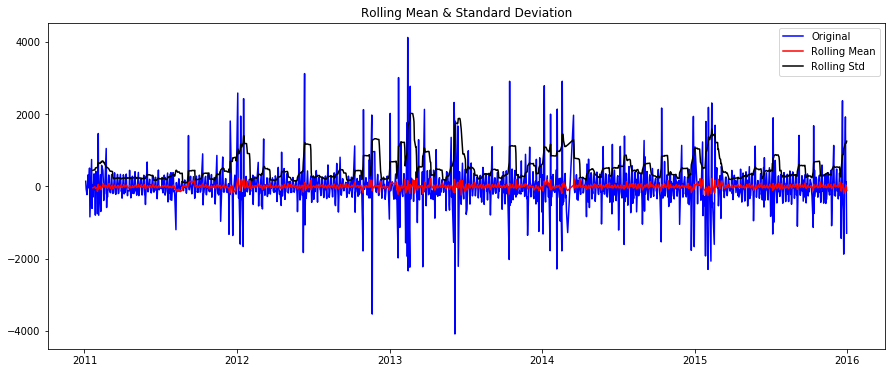

Results of Dickey-Fuller Test:
Test Statistic                -1.063005e+01
p-value                        5.242787e-19
#Lags Used                     2.200000e+01
Number of Observations Used    1.224000e+03
Critical Value (1%)           -3.435704e+00
Critical Value (5%)           -2.863904e+00
Critical Value (10%)          -2.568029e+00
dtype: float64


In [359]:
ts_diff =ts - ts.shift()
ts_diff.dropna(inplace = True)
test_stationarity(ts_diff)

In [537]:
ts.head()

Date
2011-01-03    3228.0
2011-01-04    3368.0
2011-01-05    3293.0
2011-01-06    3130.0
2011-01-07    2901.0
Name: CallVolume, dtype: float64

In [538]:
ts_diff.head()

Date
2011-01-04    140.0
2011-01-05    -75.0
2011-01-06   -163.0
2011-01-07   -229.0
2011-01-10    322.0
Name: CallVolume, dtype: float64

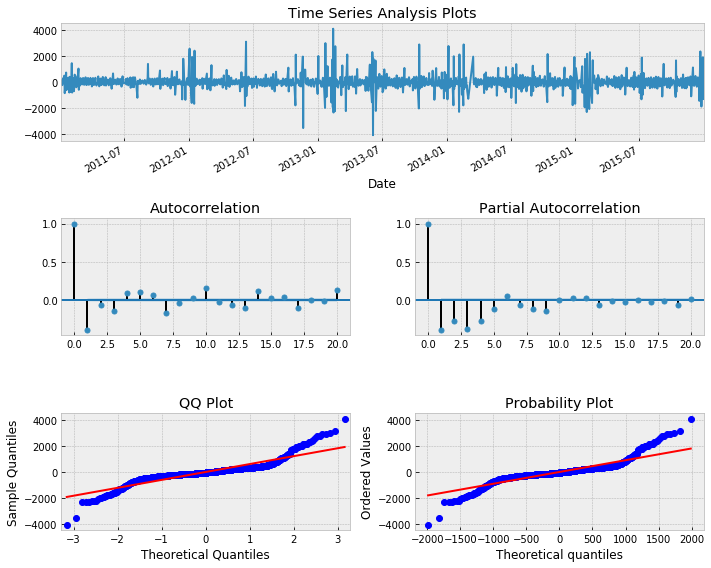

In [532]:
tsplot(ts_diff,lags=20)

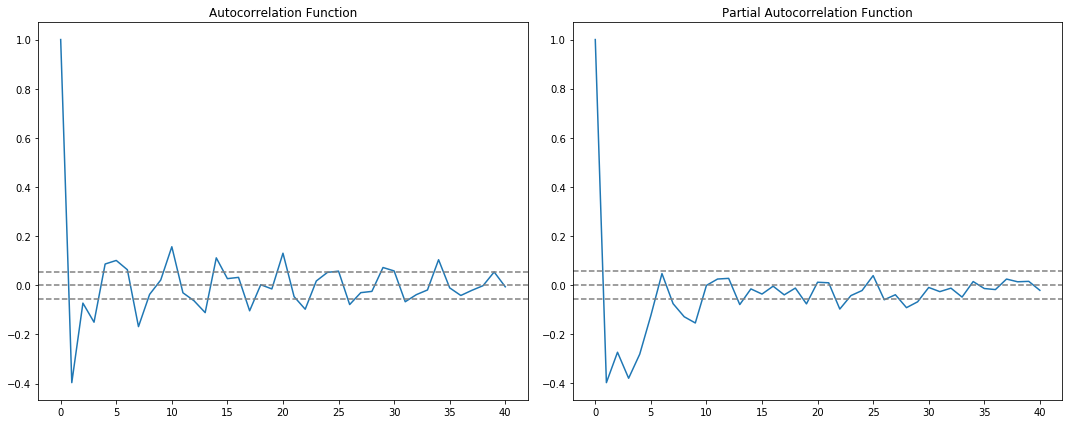

In [536]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=40)
lag_pacf = pacf(ts_diff, nlags=40, method='ols')
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

                             ARIMA Model Results                              
Dep. Variable:           D.CallVolume   No. Observations:                 1247
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -9417.457
Method:                       css-mle   S.D. of innovations            460.443
Date:                Sat, 11 Nov 2017   AIC                          18854.913
Time:                        10:11:01   BIC                          18906.198
Sample:                    01-04-2011   HQIC                         18874.195
                         - 12-31-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1293      0.808      0.160      0.873      -1.455       1.713
ar.L1.D.CallVolume     0.6654      0.056     11.903      0.000       0.556       0.775
ar.L2.D.CallVolume  

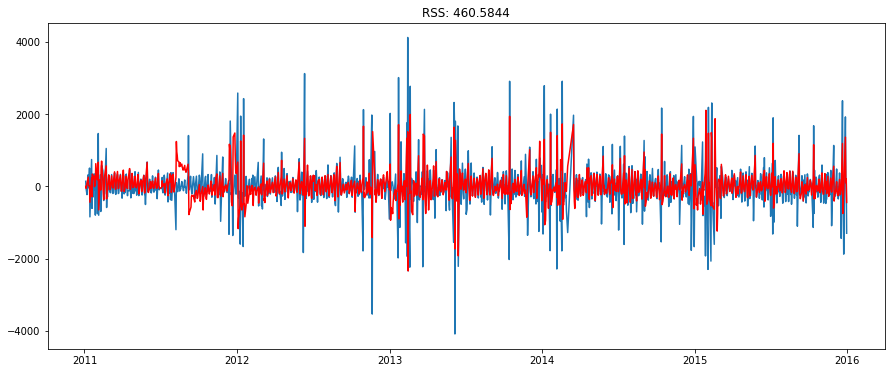

In [510]:

model = ARIMA(ts, order=(5,1,3))  
results_AR = model.fit(disp=-1)  
print(results_AR.summary())
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.32f'% sum((results_AR.fittedvalues-ts_diff)**2))
plt.title('RSS: %.4f'% sqrt(mean_squared_error(ts_diff,results_AR.fittedvalues)))

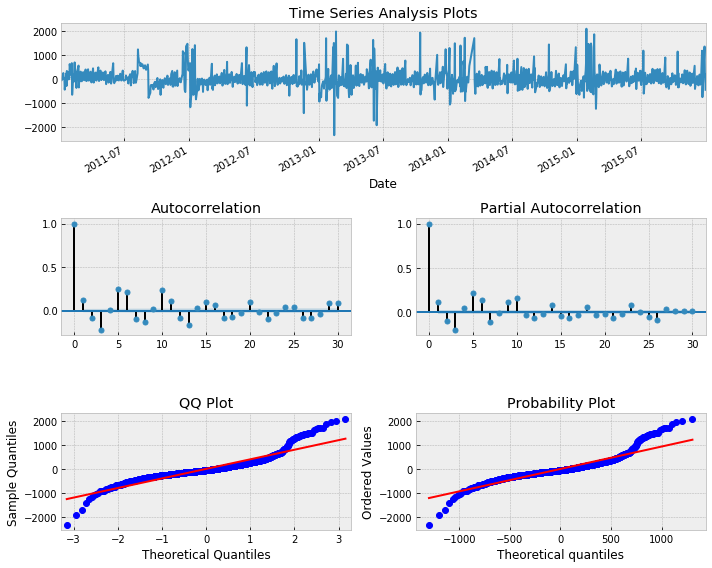

In [499]:
tsplot(results_AR.fittedvalues,lags=30)

In [511]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2011-01-04      0.129294
2011-01-05    -55.014188
2011-01-06     -0.325402
2011-01-07     82.208487
2011-01-10    254.275325
dtype: float64

In [471]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2011-01-04      0.129294
2011-01-05    -54.884895
2011-01-06    -55.210297
2011-01-07     26.998190
2011-01-10    281.273516
dtype: float64

In [473]:
predictions_ARIMA_log = pd.Series(ts.iloc[0], index=ts_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff,fill_value=0)
predictions_ARIMA_log.head()

Date
2011-01-04    3228.129294
2011-01-05    3172.985812
2011-01-06    3227.674598
2011-01-07    3310.208487
2011-01-10    3482.275325
dtype: float64

In [540]:
ts.tail()

Date
2015-12-24    1182.0
2015-12-28    3103.0
2015-12-29    3210.0
2015-12-30    3336.0
2015-12-31    2039.0
Name: CallVolume, dtype: float64

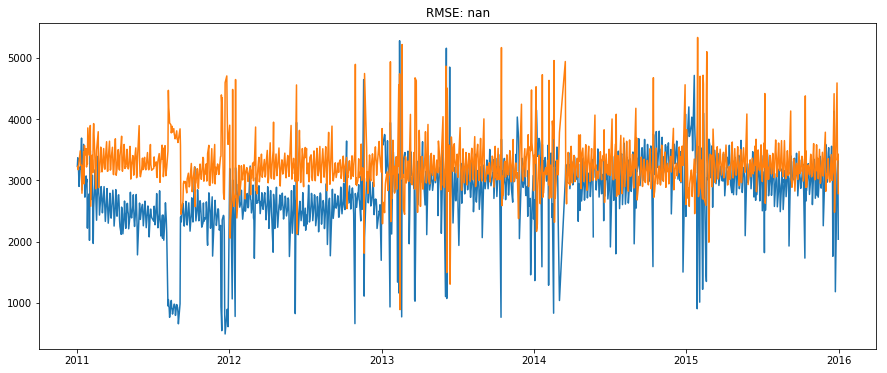

In [552]:
#predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [564]:
from pandas import datetime
start_date = datetime(2017,1,1)
end_date = datetime(2017,1,31)
forecast=results_AR.forecast(steps=30)[0]
X = ts.values
days_in_year = 365
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1
#forecast_data = pd.Series(forecast, copy=True)
#forecast.head()
#forecast_cumsum = forecast_data.cumsum()
#forecast_cumsum.head()
#forecast_log = pd.Series(forecast_data.iloc[0], index=forecast_data.index)
#forecast_log = forecast_log.add(forecast_data,fill_value=0)
#forecast_log.head()
#def inverse_difference(history, yhat, interval=1):
#	return yhat + history[-interval]
#day = 1
#for yhat in forecast:
#	inverted = inverse_difference(ts, yhat, 365)
#	print('Day %d: %f' % (day, inverted))
#	history.append(inverted)
#	day += 1

Day 1: 2937.549292
Day 2: 3445.991153
Day 3: 3179.087993
Day 4: 3058.895079
Day 5: 2538.472598
Day 6: 3088.560205
Day 7: 3399.573495
Day 8: 3432.575511
Day 9: 3332.575816
Day 10: 2603.575863
Day 11: 3174.575870
Day 12: 3605.575871
Day 13: 3136.575871
Day 14: 2947.575871
Day 15: 2611.575871
Day 16: 2971.575871
Day 17: 3375.575871
Day 18: 3138.575871
Day 19: 3333.575871
Day 20: 2628.575871
Day 21: 2961.575871
Day 22: 3352.575871
Day 23: 3092.575871
Day 24: 2998.575871
Day 25: 2818.575871
Day 26: 3155.575871
Day 27: 3461.575871
Day 28: 3392.575871
Day 29: 3009.575871
Day 30: 1963.575871
